In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
img_rows = 45
img_cols = 45
channels = 3
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [3]:
def generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(256*5*5, input_dim=z_dim))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((5,5,256)))
    model.add(Conv2DTranspose(512,kernel_size=3,strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(3,kernel_size=3,strides=2))
    model.add(Activation('sigmoid'))
    #print(model.summary())
    z = Input(shape=(z_dim,))
    img = model(z)
    
    return Model(z, img)

In [4]:
def discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64,kernel_size=3,strides=2))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(96,kernel_size=3,strides=1))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    img = Input(shape=img_shape)
    prediction = model(img)
    
    return Model(img, prediction)

In [5]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy'])
generator = generator(img_shape,z_dim)
z = Input(shape=(100,))
img=generator(z)

discriminator.trainable = False

prediction = discriminator(img)

combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5))

In [6]:
# Load Data
import os
from PIL import Image
def load_data(DIR):
    dataset = []
    for path in os.listdir(DIR):
        new_data = Image.open(DIR + '/' + path)
        n_d = np.array(new_data)
        n_d = np.true_divide(n_d, 255)
        #n_d = np.subtract(n_d, 1)
        dataset.append(n_d)
        new_data.close()
    return np.array(dataset)

In [7]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    X_train = load_data('./LR-45')
    #X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = combined.train_on_batch(z, real)
        
        if iteration % sample_interval == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                 (iteration, d_loss[0], 100*d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])
            sample_images(iteration)

In [8]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows*image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                           figsize=(4,4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [9]:
iterations = 10000
batch_size = 128
sample_interval = 1000

0 [D loss: 0.767301, acc.: 34.38%] [G loss: 0.719035]
1000 [D loss: 0.815178, acc.: 28.91%] [G loss: 0.880107]
2000 [D loss: 0.664772, acc.: 58.20%] [G loss: 0.742432]
3000 [D loss: 0.705879, acc.: 49.22%] [G loss: 0.846147]
4000 [D loss: 0.711155, acc.: 46.48%] [G loss: 1.082578]
5000 [D loss: 0.727658, acc.: 46.09%] [G loss: 0.992473]
6000 [D loss: 0.761398, acc.: 36.33%] [G loss: 0.956048]
7000 [D loss: 0.827456, acc.: 37.50%] [G loss: 0.775820]
8000 [D loss: 0.562052, acc.: 73.44%] [G loss: 1.080530]
9000 [D loss: 0.416605, acc.: 76.17%] [G loss: 1.749392]
1376.907436132431


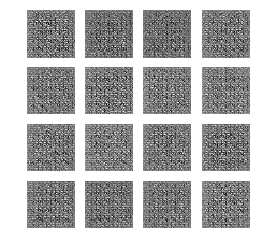

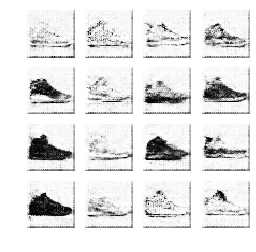

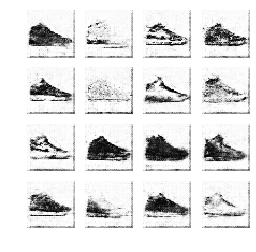

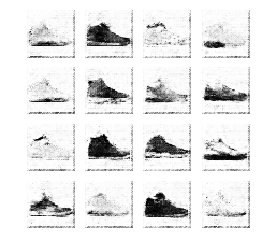

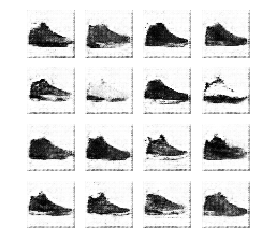

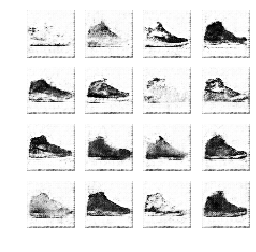

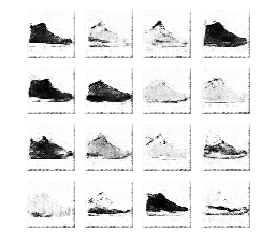

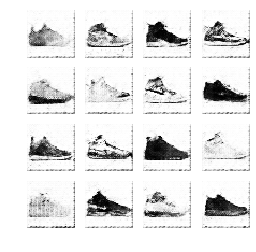

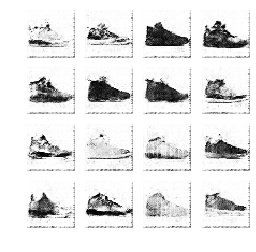

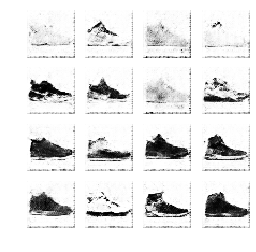

In [24]:
import warnings; warnings.simplefilter('ignore')
import time
start = time.time()
train(iterations, batch_size, sample_interval)
print(time.time() - start)

(1, 45, 45, 3)
(45, 45, 3)


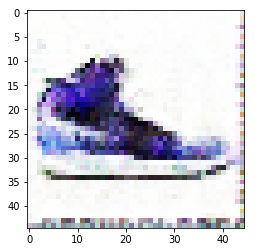

In [33]:
z = np.random.normal(0, 1, (1, 100))
img = generator.predict(z)
print(img.shape)
img = img[0,:,:, :]
print(img.shape)
plt.imshow(img)